# Final project
The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step 1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

## Step 2

Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and one

## Step 3

Solve the problem for all combinations of

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

Plot the final solution at $t=1$ in all cases. What do you observe? What happens when you increase ndofs and keep dt constant? 

## Step 4 (Optional)

Instead of solving the problem explicitly, solve it implicitly, by using backward euler method also for the non linear term. This requires the solution of a Nonlinear problem at every step. Use scipy and numpy methods to solve the non linear iteration.

In [2]:
%pylab inline
import sympy as sym
import scipy
from scipy.interpolate import *
from scipy.integrate import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
n = 1025 # number of sample points for evaluation
m = 16 # number of support points (i.e. dimension of vector space for approximation)
x = linspace(0,1, n) # equispaced points in interval for evaluation
q = linspace(0,1, m)
degree = 1
eta_init_func = lambda x: sin( 2 * pi * x ) + 1

def f(eta):
    '''
    Input : * 1D ndarray, points in interval where to evaluate standard double well potential 
    
    Output: * 1D ndarray, evaluation of standard double well potential at inputs
    '''
    return eta**2 * (eta-1.)**2

def ref_sol(x, f):
    return 0.5 * sign(f(x)-0.5) + 0.5

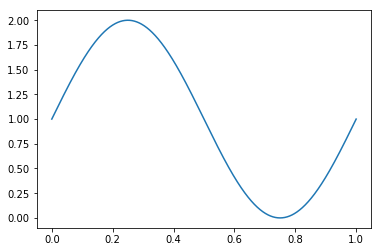

In [3]:
_ = plot(x, eta_init_func(x))

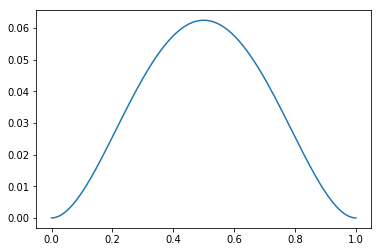

In [4]:
_ = plot(x,f(x))

In [5]:
# Step 1.1

def F(eta):
    '''
    Input : * 1D ndarray, points in interval where to evaluate derivative of standard double well potential 
    
    Output: * 1D ndarray, evaluation of derivative of standard double well potential at inputs
    '''
    return 2. * eta * ( 2. * eta**2 - 3. * eta +1. )

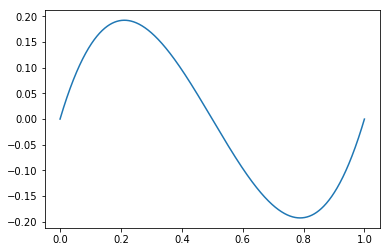

In [6]:
_ = plot(x,F(x))

In [7]:
# Step 1.2

def compute_basis_functions(support_points, degree):
    '''
    Input : * 1D ndarray support_points, points in interval giving support points for constructing 
                                         basis of piecewise polynomial objects.
            * int degree, specifies degree of the spline fit on each sub-interval.
    
    Output: * list basis, list of piecewise polynomials (objects of class scipy.interpolate.PPoly) 
                          with basis of space of polynomials of degree at most support_points.shape-1 
                          contructed by interpolating splines of input degree. 
            * list dbasis, list of piecewise polynomials (objects of class scipy.interpolate.PPoly) 
                           with derivatives of basis functions.
    '''
    basis = []
    M = support_points.shape[0]
    for i in range(M):
        c = zeros(M)
        c[i] = 1
        bi = PPoly.from_spline(splrep(support_points,c,k=degree))
        basis.append(bi)
    return basis

In [8]:
B = compute_basis_functions(q, degree)

In [9]:
def evaluate_list_functions(x, list_functions):
    N = x.shape[0]9
    M = len(list_functions)
    E = zeros((N, M))
    for i in range(M):
        E[:,i] = list_functions[i](x)
    return E

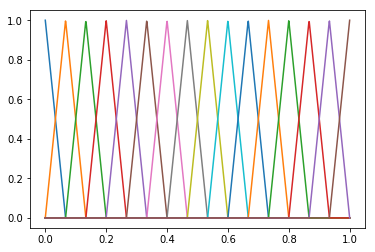

In [10]:
_ = plot(x, evaluate_list_functions(x,B))

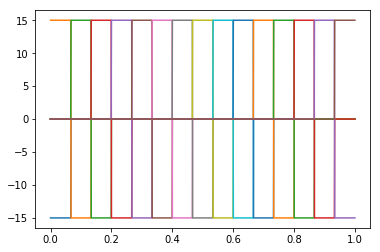

In [11]:
_ = plot(x, evaluate_list_functions(x, [b_i.derivative(1) for b_i in B]))

In [12]:
# Step 1.3

def compute_global_quadrature(basis, n_gauss_quadrature_points):
    '''
    Input : * list basis, list of objects of class scipy.interpolate.PPoly defining same piecewise subdivision, 
                          for instance as given by piecewise polynomial basis.
            * int n_gauss_quadrature_points, number of sample points and weights for each subinterval 
                                             (d+1 if considering piecewise interpolation with degree d splines).
    
    Output: * global_quadrature, 1D ndarray containing sample points for exact integration on interval [0,1]
            * global_weights, 1D ndarray containing weigths for exact integration over [0,1]
    '''
    
    # extract interval of piecewise subdivision 
    intervals = unique(basis[0].x)
    
    # compute quadrature points and weights and rescale for interval [0,1]
    qp, w = numpy.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    qp = (qp+1)/2.
    w /= 2.
    
    # replicate points and weights in all the intervals of piecewise subdivision
    h = diff(intervals)
    global_quadrature = array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    return global_quadrature, global_weights

In [13]:
# Step 1.4

def compute_system_matrices(basis, global_quadrature, global_weights):
    '''
    Input : 
    
    Output: 
    '''
    dbasis = [b_i.derivative(1) for b_i in basis]
    Bq = array([b_i(global_quadrature) for b_i in basis]).T
    dBq = array([db_i(global_quadrature) for db_i in dbasis]).T
    M = einsum('ki, k, kj', Bq, global_weights, Bq)
    K = einsum('ki, k, kj', dBq, global_weights, dBq)

    return M, K

In [14]:
# Step 2.1

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    ## prepare matrix for results
    T = 1. 
    n_times = int(T/dt)
    eta = zeros((n_times+1, ndofs))
    
    # calculate time independent parts of the system
    support_points = linspace(0,1, ndofs)
    basis = compute_basis_functions(support_points, degree)
    Q, W = compute_global_quadrature(basis, degree + 1)
    M, K = compute_system_matrices(basis, Q, W)
    A = M + dt * eps**2 * K
    
    eta[0,:] = eta_0_function(support_points)
    for i in range(n_times):
        rhs = M.dot(eta[i,:] - dt * F(eta[i,:]))
        eta[i+1,:] = linalg.solve(A, rhs)
        
    return eta, basis    

In [15]:
# Step 2.2 

def plot_solution(eta, basis, stride, resolution):
    x = linspace(0,1,resolution)
    plot(x, (evaluate_list_functions(x,basis).dot(eta.T))[:,::stride])
    plot(x, ref_sol(x,eta_init_func), color = 'r')

In [16]:
eta, b = solve_allen_cahan(eta_init_func, 0.001, 0.0625/4, 64, 3)

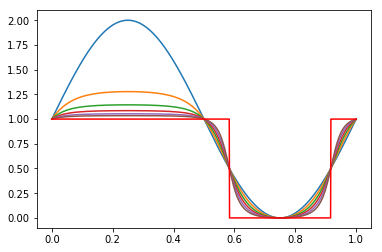

In [19]:
plot_solution(eta, b, 64, 1025)

In [148]:
x[eta_init_func(x)>0.5].shape

(684,)